In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [32]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import vits, melgan, hifigan
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from malaya_speech.train.loss import calculate_3d_loss

In [5]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [6]:
wav['wav'].shape

(1, 104448)

In [7]:
config = vits.Config(mel = 80, vocabs = 66)

In [8]:
model = vits.Model(config)

In [9]:
i = tf.convert_to_tensor([data['text_ids'][0],data['text_ids'][0]])
i_lengths = tf.convert_to_tensor([data['len_text_ids'][0,0], data['len_text_ids'][0,0]])
mel_outputs = tf.convert_to_tensor([data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]])
mel_lengths = tf.convert_to_tensor([408,408])
wavs = tf.convert_to_tensor([wav['wav'].astype(np.float32)] * 2)[:,0]
wavs.shape

TensorShape([Dimension(2), Dimension(104448)])

In [10]:
# i = tf.placeholder(tf.int32, [None, None])
# i_lengths = tf.placeholder(tf.int32, [None])
# mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
# mel_lengths = tf.placeholder(tf.int32, [None])

In [11]:
losses, attn, latent, mel_hat, ids_slice = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
loss = losses['nll'] + losses['durloss']
loss, losses, attn


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor: id=41685, shape=(), dtype=float32, numpy=2.013537>,
 {'nll': <tf.Tensor: id=41415, shape=(), dtype=float32, numpy=1.7886044>,
  'durloss': <tf.Tensor: id=41614, shape=(), dtype=float32, numpy=0.22493249>},
 <tf.Tensor: id=41396, shape=(2, 408, 72), dtype=float32, numpy=
 array([[[1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 0., 1.]],
 
        [[1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 0., 1.]]], dtype=float32)>)

In [12]:
mel = vits.slice_segments(mel_outputs, ids_slice, model.segment_size // model.hop_size, np.log(1e-2))

In [13]:
y = vits.slice_segments(tf.expand_dims(wavs, -1), ids_slice * model.hop_size, model.segment_size)

In [14]:
y

<tf.Tensor: id=41797, shape=(2, 104448, 1), dtype=float32, numpy=
array([[[-0.00032019],
        [-0.00045306],
        [-0.00029016],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.05932664],
        [ 0.04855074],
        [ 0.0359837 ],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]], dtype=float32)>

In [19]:
hifigan_config = malaya_speech.config.hifigan_config
generator = hifigan.Generator(
    hifigan.GeneratorConfig(**hifigan_config['hifigan_generator_params']),
    name='hifigan_generator',
)
multiperiod_discriminator = hifigan.MultiPeriodDiscriminator(
    hifigan.DiscriminatorConfig(
        **hifigan_config['hifigan_discriminator_params']
    ),
    name='hifigan_multiperiod_discriminator',
)
multiscale_discriminator = melgan.MultiScaleDiscriminator(
    melgan.DiscriminatorConfig(
        **hifigan_config['melgan_discriminator_params'],
        name='melgan_multiscale_discriminator',
    )
)
discriminator = hifigan.Discriminator(
    multiperiod_discriminator, multiscale_discriminator
)

In [22]:
y_hat = generator(mel_hat, training = True)
y_hat.shape

TensorShape([Dimension(2), Dimension(104448), Dimension(1)])

In [25]:
y.shape, y_hat.shape

(TensorShape([Dimension(2), Dimension(104448), Dimension(1)]),
 TensorShape([Dimension(2), Dimension(104448), Dimension(1)]))

In [28]:
# p = discriminator(y)
# p_hat = discriminator(y_hat)

# real_loss = 0.0
# fake_loss = 0.0
# for i in range(len(p)):
#     real_loss += calculate_3d_loss(
#         tf.ones_like(p[i][-1]), p[i][-1], loss_fn=mse_loss
#     )
#     fake_loss += calculate_3d_loss(
#         tf.zeros_like(p_hat[i][-1]), p_hat[i][-1], loss_fn=mse_loss
#     )
# real_loss /= i + 1
# fake_loss /= i + 1
# dis_loss = real_loss + fake_loss

In [34]:
mae_loss = tf.keras.losses.MeanAbsoluteError()

# p = discriminator(y)
# p_hat = discriminator(y_hat)

# adv_loss = 0.0
# for i in range(len(p_hat)):
#     adv_loss += calculate_3d_loss(
#         tf.ones_like(p_hat[i][-1]), p_hat[i][-1], loss_fn=mse_loss
#     )
# adv_loss /= i + 1

# fm_loss = 0.0
# for i in range(len(p_hat)):
#     for j in range(len(p_hat[i]) - 1):
#         fm_loss += calculate_3d_loss(
#             p[i][j], p_hat[i][j], loss_fn=mae_loss
#         )

# fm_loss /= (i + 1) * (j + 1)
# adv_loss += 1.0 * fm_loss
# generator_loss = 1.0 * adv_loss

mel_loss = calculate_3d_loss(mel, mel_hat, loss_fn=mae_loss)

In [35]:
mel_, mellen_, attn_out = model(inputs = i, lengths = i_lengths)
mel_, mellen_, attn_out

(<tf.Tensor: id=55092, shape=(2, 72, 80), dtype=float32, numpy=
 array([[[ 1.3382952 , -2.3203902 , -0.05735631, ..., -2.0966027 ,
           1.1668291 , -3.0503705 ],
         [ 0.91121674, -2.056521  , -0.6015806 , ..., -1.854808  ,
           1.0289947 , -3.2254581 ],
         [ 1.1407169 , -2.5102491 , -0.2700694 , ..., -1.6935581 ,
           0.53416264, -2.4997473 ],
         ...,
         [ 1.166632  , -2.294219  , -0.24967219, ..., -2.1218557 ,
           0.37705684, -2.1272073 ],
         [ 0.9751956 , -1.3155334 , -0.3481895 , ..., -2.3949215 ,
           0.23429692, -2.4079933 ],
         [ 0.87337714, -2.344386  , -0.31554428, ..., -2.1807084 ,
           1.1234126 , -2.752566  ]],
 
        [[ 1.4086277 , -2.0349698 , -0.1914409 , ..., -2.3998785 ,
           1.1674811 , -3.0897782 ],
         [ 0.63280755, -2.0530264 ,  0.1899319 , ..., -1.4064708 ,
           1.2321851 , -3.3552773 ],
         [ 1.427983  , -2.0271006 ,  0.22411273, ..., -2.2650537 ,
           1.296613 

In [36]:
# optimizer = tf.train.AdamOptimizer(learning_rate = 1e-6, beta1 = 0.9, 
#                                    beta2 = 0.98, epsilon = 1e-9).minimize(loss)

In [38]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.9, 
                                   beta2 = 0.98, epsilon = 1e-9)

In [39]:
for k in range(100):
    with tf.GradientTape() as tape:
        losses, attn, latent, mel_hat, ids_slice = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
        mel = vits.slice_segments(mel_outputs, ids_slice, model.segment_size // model.hop_size, np.log(1e-2))
        mel_loss = calculate_3d_loss(mel, mel_hat, loss_fn=mae_loss)
        loss = losses['nll'] + losses['durloss'] + mel_loss
    print(k, losses)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

0 {'nll': <tf.Tensor: id=79411, shape=(), dtype=float32, numpy=1.7853608>, 'durloss': <tf.Tensor: id=79505, shape=(), dtype=float32, numpy=0.21968488>}
1 {'nll': <tf.Tensor: id=133129, shape=(), dtype=float32, numpy=1.2437187>, 'durloss': <tf.Tensor: id=133223, shape=(), dtype=float32, numpy=0.19173023>}
2 {'nll': <tf.Tensor: id=173546, shape=(), dtype=float32, numpy=0.91510737>, 'durloss': <tf.Tensor: id=173640, shape=(), dtype=float32, numpy=0.22489491>}
3 {'nll': <tf.Tensor: id=213963, shape=(), dtype=float32, numpy=0.76319677>, 'durloss': <tf.Tensor: id=214057, shape=(), dtype=float32, numpy=0.21980402>}
4 {'nll': <tf.Tensor: id=254380, shape=(), dtype=float32, numpy=0.64597>, 'durloss': <tf.Tensor: id=254474, shape=(), dtype=float32, numpy=0.21788907>}
5 {'nll': <tf.Tensor: id=294797, shape=(), dtype=float32, numpy=0.5251219>, 'durloss': <tf.Tensor: id=294891, shape=(), dtype=float32, numpy=0.2176168>}
6 {'nll': <tf.Tensor: id=335214, shape=(), dtype=float32, numpy=0.4347808>, 'du

53 {'nll': <tf.Tensor: id=2234813, shape=(), dtype=float32, numpy=0.25852984>, 'durloss': <tf.Tensor: id=2234907, shape=(), dtype=float32, numpy=0.19974402>}
54 {'nll': <tf.Tensor: id=2275230, shape=(), dtype=float32, numpy=0.26121074>, 'durloss': <tf.Tensor: id=2275324, shape=(), dtype=float32, numpy=0.21683714>}
55 {'nll': <tf.Tensor: id=2315647, shape=(), dtype=float32, numpy=0.26133424>, 'durloss': <tf.Tensor: id=2315741, shape=(), dtype=float32, numpy=0.20105423>}
56 {'nll': <tf.Tensor: id=2356064, shape=(), dtype=float32, numpy=0.2605756>, 'durloss': <tf.Tensor: id=2356158, shape=(), dtype=float32, numpy=0.20217243>}
57 {'nll': <tf.Tensor: id=2396481, shape=(), dtype=float32, numpy=0.26237714>, 'durloss': <tf.Tensor: id=2396575, shape=(), dtype=float32, numpy=0.20868622>}
58 {'nll': <tf.Tensor: id=2436898, shape=(), dtype=float32, numpy=0.26067123>, 'durloss': <tf.Tensor: id=2436992, shape=(), dtype=float32, numpy=0.20356953>}
59 {'nll': <tf.Tensor: id=2477315, shape=(), dtype=fl

In [40]:
mel_, mellen_, attn_out = model(inputs = i, lengths = i_lengths)
mel_, mellen_, attn_out

(<tf.Tensor: id=4116169, shape=(2, 218, 80), dtype=float32, numpy=
 array([[[ 9.4672465e-01, -3.3797920e-03, -3.7902865e-01, ...,
          -8.5847458e+01, -7.9032860e+01,  7.6018364e+01],
         [ 5.8684081e-01,  2.1966729e-01,  7.3977387e-01, ...,
           7.3723090e+02,  1.8463542e+02, -2.6185391e+02],
         [ 7.4838996e-01,  5.0120705e-01, -1.8145433e-01, ...,
          -5.4223779e+02, -1.6927847e+03,  7.5599097e+02],
         ...,
         [ 3.6053675e-01, -1.6885073e-01,  1.2564379e-01, ...,
           1.6034093e+02,  5.4373633e+03,  2.0267687e+03],
         [ 5.1232374e-01,  1.9848317e-01,  1.0724964e+00, ...,
          -1.1422634e+03, -4.4234940e+02,  2.9410373e+02],
         [ 2.7083257e-01,  1.0857319e+00,  6.9677079e-01, ...,
          -3.4140240e+02, -3.0056938e+01,  1.5914828e+02]],
 
        [[ 2.7015722e-01,  4.5537531e-01,  4.2889267e-01, ...,
           7.0915169e+01, -2.0491516e+01,  1.6757983e+02],
         [ 1.8108496e-01,  2.5254357e-01,  2.0423849e-01, ...,

In [41]:
# sess = tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())

In [42]:
# %%time

# o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
#                                                i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
#                                                mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
#                                                mel_lengths: [408, 408]})

In [43]:
# o = sess.run([mel, mellen, attn_out], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
#                                                i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
#                                         mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
#                                                mel_lengths: [408, 408]})
# o[1]

In [44]:
# for k in range(50):
#     o = sess.run([loss, losses, optimizer], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
#                                                i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
#                                                mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
#                                                mel_lengths: [408, 408]})
#     print(k, o)

In [45]:
# o = sess.run([mel, mellen, attn_out], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
#                                                i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
#                                         mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
#                                                mel_lengths: [408, 408]})

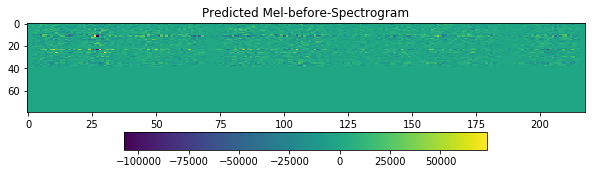

In [46]:
mel_outputs_ = np.reshape(mel_[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [ ]:
saver = tf.train.Saver()
saver.save(sess, 'test/model.ckpt')